In [ ]:
#Universidad Nacional Autónoma de México
#Posgrado en Ciencias de la Tierra 
#Campo 1, geofísica de la Tierra sólida, sismología

#Elaborado por Isaac Valverde, 2023

#Programa 5_1: Notebook de python 3 que permite probar distintos valores de alpha a partir de la estrategia semianalítica de Noquet (2018) utilizando el estimador cuasi-Monte Carlo
#Basado en la estrategia semianalítica de Noquet (2018)

#Nota: Las ecuaciones referidas en este notebook corresponden al articulo "Stochastic static fault slip inversion from geodetic data with non-negativity and bound constraints" Noquet (2018)

In [2]:
from scipy import special
from scipy.stats.mvn import mvnun
from scipy.stats import qmc
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
#Función que intercambia las filas de una matriz o vector columna, colocando el o los reglones indicados comenzando en el primer renglón 
#Entradas
#A: Matriz o vector cuyas filas serán reacomodadas
#ind: Lista con el o los números de la fila que se van a colocar en el primer renglón  
#Salida
#A1: Matriz reordenada

def reorder(A,ind):
    #Se obtienen las dimensiones de la matriz o vector a reordenar
    n1,n2=np.shape(A)
    #Se define un arreglo auxiliar para introducir los renglones que se colocan en la posición del primer renglón
    aux1=np.zeros((len(ind),n2))
    #Se genera una copia de A
    aux2=np.copy(A)
    #Se inicia un ciclo para colocar el o los renglones de interés en aux1
    for i in range (0,len(ind)):
        aux1[i]=np.copy(A[ind[i]-1])
    #Se eliminan los renglones a reacomodar de la copia de A
    aux2=np.delete(A,ind-1,axis=0)
    #Se unen los renglónes de interes con el resto (en el orden que tienen omitiendo los renglones de interés)
    A1=np.concatenate((aux1, aux2), axis=0)
    return A1

In [5]:
#Funcion que calcula el vector de medias y la matriz de covarianza de la función de densidad de probabilidad posteriora partir de las expresiones de Tarantola y Valette (1982)
#Entradas
#G: Matriz kernel de la inversión (dimensión número de datos por número de parámetros) 
#d: Vector columna que contiene los datos de desplazamiento (de dimensión 1 por número de datos)
#Cdinv: Matriz de covarianza de los datos
#alpha:Valor de alpha para aproximar la distribución apriori
#limsup: Vector que contiene el límite superior del intervalo de truncamiento de cada parámetro
#m0: Media de la distribucion apriori
#Salida
#mv: Vector de medias de la posterior
#Cmv: Matriz de covarianza de la posterior

def mvCmv(G,d,Cdinv,alpha,limsup,m0):
    
    #Se obtiene el número de parámetros
    Nm=np.shape(G)[1]
    #Se obtiene la transpuesta de la kernel G
    GT=np.transpose(G)
    #Se define la desviación estandar (pp 373, primer párrafo, quinto renglón)
    sigma=alpha*(limsup/2)
    #Se define la matriz de covarianza de los parámetros (pp) (pp 372, primer parrafo, segundo renglón)
    #Cm=np.identity(Nm)*((sigma.reshape(Nm,1))**2)
    Cm=np.identity(Nm)*(((np.ones(Nm)*sigma).reshape(Nm,1))**2)
    #Se define la inversa la matriz de covarianza de los parámetros
    Cminv=np.linalg.inv(Cm)
    #Se define la matriz de covarianza posterior (Ecuaciones de Tarantola y Valette, pp. 369, Ec. 7)
    Cmv=np.linalg.inv(np.matmul(np.matmul(GT,Cdinv),G)+Cminv)
    #Se define la transpuesta de la matriz de covarianza posterior
    CmvT=np.transpose(Cmv)
    #Se define la inversa de la matriz de covarianza posterior
    Cmvinv=np.matmul(np.matmul(GT,Cdinv),G)+Cminv
    #Se define la expectativa (Ecuaciones de Tarantola y Valette, pp. 369, Ec. 6)
    mv=np.matmul(np.linalg.inv(np.matmul(np.matmul(GT,Cdinv),G)+Cminv), np.matmul(np.matmul(GT,Cdinv),d)+np.matmul(Cminv,m0))
    return mv, Cmv

In [6]:
#Función que estima la integral de una función exponencial gaussiana mediante el método de Monte Carlo
#Entradas
#bm1: Vector de medias de la función exponencial gaussiana
#Ainv: Matriz de covarianza de la función exponencial gaussiana
#RND:Conjunto de números aleatorios en los que se evalúa la función para estimar el valor de la integral
#V: Hipervolumen de la región de integración
#Salida
#I: Valor estimado de la integral

#Funcion que calcula las marginales de una distribución de probabilidad (caso 1 y 2D)
def ExpIntegral(bm1,Ainv,RND,V):
    #Se obtiene el número de parámetros
    NM=np.shape(Ainv)[0]
    #Se obtiene el número de muestras que se van a usar para evaluar la función
    NoMuestras=np.shape(RND)[0]
    #Se inicializa una variable auxiliar para acumular la suma de los valores de la funcion evaluada en las muestras
    Iaux=0
    #Se inicia un ciclo para evaluar las muestras en la función
    for i in range(0,int(NoMuestras)): 
        #Se extrae la i-esima muestra del arreglo que contiene todas las muestras
        m2=RND[i,:].reshape(NM,1)
        #Se evalua la función y se suma al resto 
        Iaux=Iaux+np.exp(-0.5*np.matmul(np.transpose(m2-bm1),np.matmul(Ainv,m2-bm1)))
    #Se multiplica la suma de las evaluaciones de la función en las muestras por el hipervolumen de la región de integración y se divide entre el número de muestras
    I=(Iaux*V)/NoMuestras
    return I

In [7]:
#Función que calcula la marginal de una TMVN utilizando el estimador Monte Carlo para resolver las integrales
#Entradas
#m: Matriz que contiene el espacio de parámetros descretizado  
#Cmv1: Matriz de covarianza de la TMVN posterior
#mv1: Vector (columna) de medias de la TMVN posterior
#Ind1: Número de parámetro del cual se obtiene la marginal
#RND: Conjunto de números aleatorios que se utiliza para estimar las integrales mediante Monte Carlo (las filas son el número de muestras y las columnas el valor de cada parámetro)
#V: Hipervolumen de la región de integración
#Salida
#sigmMb1: Vector que contiene los valores de la marginal

def marginal_MC(m,Cmv1,mv1,Ind1,RND,V): 
    #Se obtiene una lista con todas las posibles combinaciones del espacio de parámetros
    Ind=np.array(Ind1)
    
    #Se acomodan las filas y la columnas de la matriz de covarianza posterior de los parámetros en función de la marginal requerida
    Cmv0=np.transpose(reorder(np.transpose(Cmv1),Ind))
    Cmv=reorder(Cmv0,Ind)

    #Se acomodan los elementos del vector expectativa en función de la marginal requerida
    mv=reorder(mv1,Ind)
    
    #Se obtienen la dimensión de la submatriz m1
    NmM=len(Ind)
    #Se obtiene el número de parámetros
    Nm=np.shape(m)[1]
    #Se obtiene el vector recorrido de las marginales
    mn=m[0:len(m),0]
    
    #Se definen las submatrices necesarias para las operaciones del calculo de las marginales
    Cmvinv11=np.linalg.inv(np.array([Cmv[0:NmM,0:NmM]]).reshape(NmM,NmM))
    Cmv12=Cmv[0:NmM,NmM:Nm].reshape(NmM,Nm-NmM)
    CmvT12=np.transpose(Cmv12).reshape(Nm-NmM,NmM)
    Cmv22=Cmv[NmM:Nm,NmM:Nm]
    mv1=mv[0:NmM,0].reshape(NmM,1)
    mv2=mv[NmM:len(mv),0].reshape(Nm-NmM,1)
    m1=m[:,0:NmM]
    
    #Matriz de covarianza para la función integral
    A=Cmv22-np.matmul(CmvT12,np.matmul(Cmvinv11,Cmv12))
    #Se obtiene la inversa de la matriz de covarianza para la función integral
    Ainv=np.linalg.inv(A)
    
    #Se define un arreglo para almacenar los datos de la integral
    Integral=np.zeros((len(mn)**(NmM-1),len(mn)))
    #Se define un arreglo para almacenar
    Campana=np.zeros((len(mn)**(NmM-1),len(mn)))
    
    #Se define un vector que contiene el límite inferior de los parámetros agrupados en m2
    linf_m2=m[0,0:Nm]
    #Se define un vector que contiene el límite superior de los parámetros agrupados en m2
    lsup_m2=m[-1,0:Nm]
    
    for i in range(0,len(mn)):
        #Se obtiene el valor de la media para la marginal m1 (pp. 369, cuarta ecuación bajo la ecuación 10)
        b=mv2+np.matmul(CmvT12,np.matmul(Cmvinv11,m1[i]-mv1))
        #Se obtiene la función integral (Ec. 11, pp. 369)
        Integral[0][i]=ExpIntegral(b,Ainv,RND,V)
        #Se evalúa la función exponencial de la ec. 11
        Campana[0][i]=np.exp(-0.5*np.matmul(np.transpose(m1[i]-mv1),np.matmul(Cmvinv11,m1[i]-mv1)))
    
    #Se obtiene el producto de la función exponencial y de la función integral de la marginal (Ec. 11, pp. 369)                
    sigmMb1=Campana[0]*Integral[0]
    #Se normaliza la marginal en el intervalo de truncamiento
    sigmMb1=sigmMb1/np.trapz(sigmMb1,x=mn,dx=(mn[1]-mn[0]))
    
    #np.savetxt("marginal_m"+str(Ind[0])+"_alpha8_sob.txt", sigmMb1) #Descomentar para escribir un archivo de texto con los datos de la marginal
    
    return sigmMb1

In [8]:
#Función que calcula la media, desviación estandar y coeficiente de variación de las marginales
#Entradas
#marg: Vector que contiene los valores de la marginal
#x: Vector que contiene los valores en los que se evalúa la marginal (intervalo de truncamiento de la marginal)
#Salida
#Mean: Media de la marginal
#Sd: Desviación estandar de la marginal
#CV: Coeficiente de variación de la marginal

def Estadisticas(marg,x):
    #Se calcula la media de la marginal
    Mean=np.trapz(marg*x,x=x,dx=(x[1]-x[0]))
    #Se calcula la desviación estandar de la marginal
    Sd=(np.trapz(marg*(x-Mean)**2,x=x,dx=(x[1]-x[0])))**(0.5)
    #Se calcula el coeficiente de variación de la marginal
    CV=(Sd/Mean)*100
    
    return Mean,Sd,CV

In [9]:
#------------------------------------------------------------------------------------------------------------
#------------------------------------Problema complejo-------------------------------------------------------
#------------------------------------------------------------------------------------------------------------

In [10]:
#Se define el número de datos (3 componentes por 11 estaciones)
Nd=33
#Se define el número de parámetros (Discretización de falla de 18x18)
Nm=324
#Discretización de cada parámetro 
Ndm=50

In [11]:
#----------------------------Lectura y asignación de datos----------------------------

#Se extraen los datos de la matriz G
Gfile=open("G324.txt", "r")
Gstr=Gfile.read()
Gstrsplit=Gstr.split()

#Se extraen los datos de las estaciones
dfile=open("d.txt", "r")
dstr=dfile.read()
dstrsplit=dstr.split()

#Se define un arreglo para la matriz G
G=np.zeros((Nd,Nm))
#Se define un arreglo para los datos
d=np.zeros((Nd,1))

#Se almacenan los datos de la matriz G y el vector d en los arreglos correspondientes
for i in range (0,Nd):
    G[i,:]=np.array(Gstrsplit[(i*(Nm)):(i*(Nm))+Nm])
    d[i][0]=float(dstrsplit[i])
    
#Se define la transpuesta de la matriz G   
GT=np.transpose(G)

In [12]:
#----------------------------Matriz de covarianza de los datos----------------------------
#Se definen los valores de varianza de cada componente por estación
Vd=[2.1**2,2.5**2,5.1**2]*int(Nd/3)
#Se convierte le lista de valores a un arreglo numpy y las unidades a metros
Vd=np.array(Vd)*(10**-3)
#Se especifíca el vector de varianzas como vector columna
Vd=Vd.reshape(Nd,1)
#Se define una matriz cuya diagonal corresponde al vector de varianzas para obtener la matriz de covarianza de los datos
Cd=Vd*np.identity(Nd)
#Se obtiene la inversa de la matriz de covarianza de los datos
Cdinv=np.linalg.inv(Cd)

In [13]:
#------------------------Espacio de parámetros------------------------

#Se define el límite inferior de los parámetros
liminf=-0.004931
#Se define el límite superior de los parámetros
limsup=4.931506

#Se define un vector con el límite inferior de cada parámetro
a=np.zeros((1,Nm))+liminf
#Se define un vector con el límite superior de cada parámetro
b=np.zeros((1,Nm))+limsup
#Se define un vector con diferentes valores de alpha
alpha=np.arange(1,13,1)
#Se define un vector con los valores posibles para un parámetro
mn=np.linspace(liminf,limsup,Ndm)
#Se define una matriz que representa el espacio de parámetros
m=np.zeros((len(mn),Nm))+mn.reshape(Ndm,1)
#Se define un vector con la media de los parámetros (pp 372, primer parrafo, tercer renglón)
m0=np.zeros((Nm,1))+(limsup/2)

In [14]:
#Se define un vector con el límite inferior del rango de truncamiento de cada parámetro
linf_params=m[0,0:Nm-1]
#Se define un vector con el límite superior del rango de truncamiento de cada parámetro
lsup_params=m[-1,0:Nm-1]
#Se obtiene el hipervolumen de la región de integración 
V_params=(liminf-limsup)**(Nm-1)
#Se define la secuencia utilizada para estimar las integrales
sampler=qmc.Sobol(d=Nm-1, scramble=True, seed=10)
sample=sampler.random_base2(m=4)
RND_params=qmc.scale(sample, linf_params, lsup_params)

In [16]:
#Se inicializa un arreglo para almacenar los coeficientes de variación para los distintos valores de alpha
CV=np.zeros((len(alpha),Nm)) 
for i in range(0, len(alpha)): #Se recorren los distintos valores de alpha
    #Se calcula el vector de medias y la matriz de covarianza de la posterior para el i-esimo valor de alpha
    mv_aux,Cmv_aux=mvCmv(G,d,Cdinv,alpha[i],limsup,m0)
    for j in range(0,Nm): #Se recorren los parámetros
        #Se obtiene la marginal del j-ésimo parámetro
        Sig_maux=marginal_MC(m,Cmv_aux,mv_aux,[j+1],RND=RND_params,V=V_params)
        #Se caclula la media, la desviación estandar y el coeficiente de variación del j-ésimo parámetro
        mean,sd,cv=Estadisticas(Sig_maux,mn)
        #Se almacena el valor de coeficiente de variación del j-ésimo parámetro para el i-esimo valor de alpha
        CV[i,j]=cv

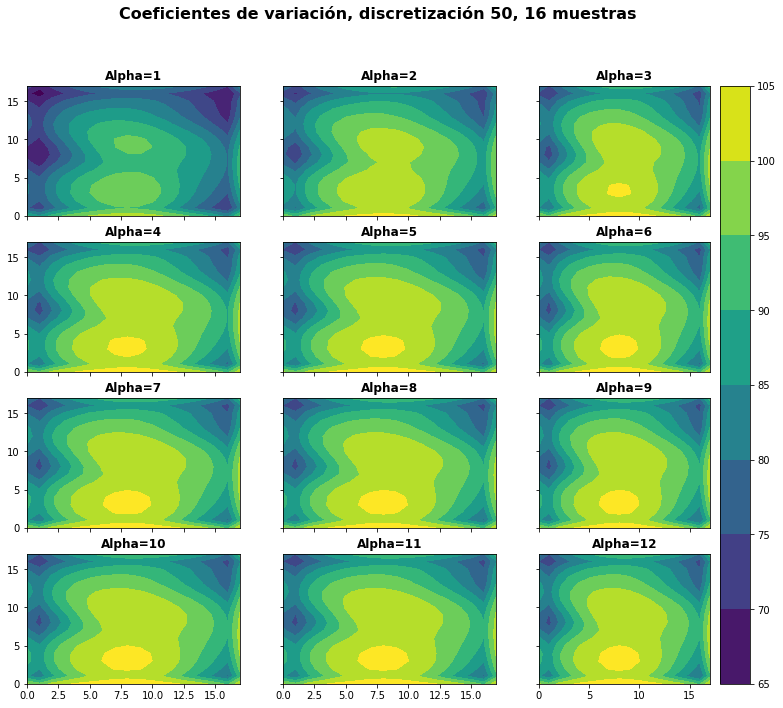

In [17]:
#Se despliega una gráfica para analizar 12 valores de alpha con los cuales se calculan los coeficientes de variación

fig, axs = plt.subplots(4, 3,figsize=(13, 11))
aux=0

aux_bar=np.zeros((2,2))
aux_bar[:,0]=np.min(CV)
aux_bar[:,1]=np.max(CV)

im=plt.contourf(aux_bar)

for i in range(0,4):
    for j in range(0,3):
        axs[i, j].contourf(np.rot90(CV[aux,:].reshape(18,18),k=3),vmin=np.min(CV), vmax=np.max(CV))
        axs[i, j].set_title('Alpha='+str(alpha[aux]),fontsize=12,fontweight=600)
        aux=aux+1
        
plt.suptitle('Coeficientes de variación, discretización '+str(Ndm)+", "+str(2**4)+" muestras",fontsize=16,fontweight=600)

plt.colorbar(im, ax=axs[:,2])

for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig("AnalisisAlpha.png",dpi=400,bbox_inches='tight')
plt.show()